# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [6]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

100%|████████████████████████████████████████| 170M/170M [31:04<00:00, 91.4kB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

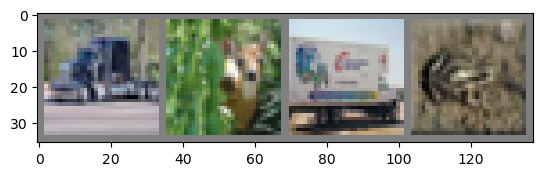

truck deer truck frog


In [6]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [9]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv_0 = nn.Conv2d(3, 32, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        
        self.conv2d_res = nn.Conv2d(3, 32, kernel_size=1)
        self.pool = nn.AvgPool2d(8)
        self.linear = nn.Linear(in_features=512, out_features=10)
        

    def forward(self, x):
        main_x = self.bn2(self.conv_2(self.relu(self.bn1(self.conv_1(x)))))
        add_x = self.conv_0(x)
        out_ = self.pool(self.relu(main_x + add_x))
        out = self.linear(torch.flatten(out_, start_dim=1))

        return out

In [10]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2d_res): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [11]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [12]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps:0


In [13]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [17]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        data = data.to(device)
        target = target.to(device)
        
        logits = model(data)
        loss = nn.functional.cross_entropy(logits, target)
        
        loss_log.append(loss.item())
        
        # <your code here>
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        
        # <your code here>
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data)
        loss = nn.functional.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        # <your code here>
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [18]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.43800684847823, train acc: 0.4886189279652165
 val loss: 1.2385197383292177, val acc: 0.5581560284533399

Epoch 1
 train loss: 1.144142543158104, train acc: 0.5962310655679302
 val loss: 1.1015817756348467, val acc: 0.6131205672913409

Epoch 2
 train loss: 1.0355268665597905, train acc: 0.6388621376027137
 val loss: 1.0094080189441113, val acc: 0.6466312055892133

Epoch 3
 train loss: 0.9800527768117636, train acc: 0.6622445482004713
 val loss: 1.025925820178174, val acc: 0.6384530140998516

Epoch 4
 train loss: 0.943973871319124, train acc: 0.6722953121230633
 val loss: 1.020514028630358, val acc: 0.6541666667512123

Epoch 5
 train loss: 0.9202652899395177, train acc: 0.6813054975033678
 val loss: 0.9439395432776593, val acc: 0.678036347602276

Epoch 6
 train loss: 0.8883917616642807, train acc: 0.6961714873802074
 val loss: 0.9736133512030256, val acc: 0.6648936170212766

Epoch 7
 train loss: 0.8683013688275757, train acc: 0.7010805692925531
 val loss: 0.933860

Посчитайте точность на тестовой выборке:

In [19]:
loss_, acc_ = test(net, test_loader)
np.mean(acc_)

0.7108877388535032

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

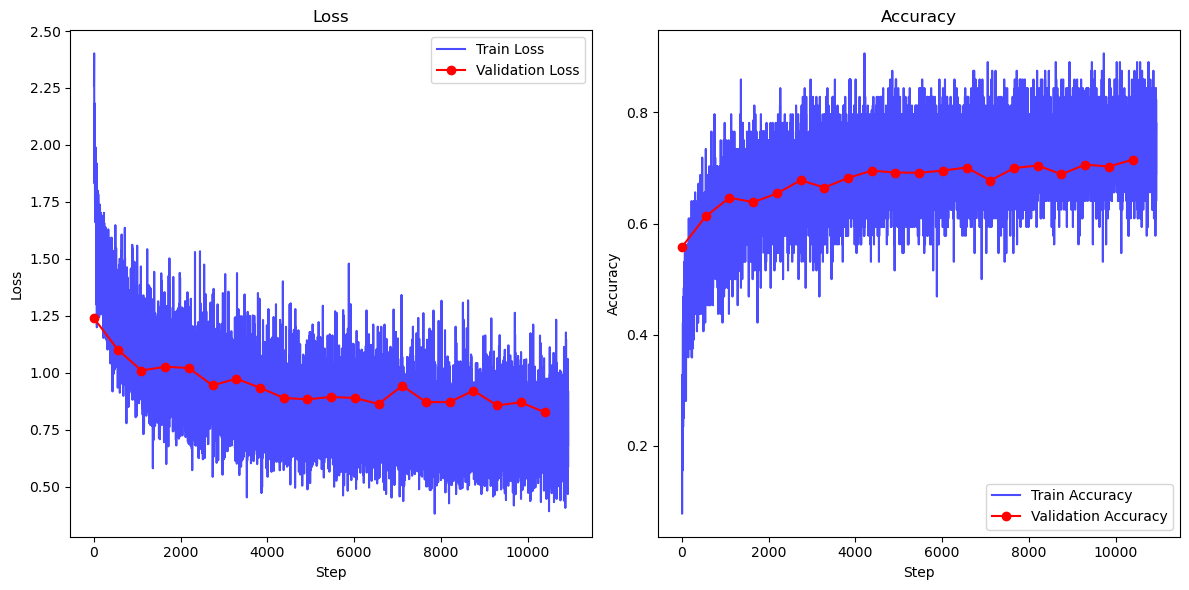

In [24]:
import matplotlib.pyplot as plt

steps_train = len(train_loss_log) 
epochs_val = len(val_loss_log)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(steps_train), train_loss_log, label='Train Loss', color='blue', alpha=0.7)
plt.plot(range(0, steps_train, steps_train // epochs_val), val_loss_log, label='Validation Loss', color='red', marker='o')

plt.title('Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(steps_train), train_acc_log, label='Train Accuracy', color='blue', alpha=0.7)
plt.plot(range(0, steps_train, steps_train // epochs_val), val_acc_log, label='Validation Accuracy', color='red', marker='o')

plt.title('Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [25]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5104384178217412, train acc: 0.4576953839122486
 val loss: 1.3387784968031213, val acc: 0.5278147162275112

Epoch 1
 train loss: 1.2012800040367098, train acc: 0.5771415513655821
 val loss: 1.0984735214963872, val acc: 0.6180851063829788

Epoch 2
 train loss: 1.0845359252183486, train acc: 0.6204500196184929
 val loss: 1.0971490380611826, val acc: 0.619437056653043

Epoch 3
 train loss: 1.0280102420550596, train acc: 0.6424857991487061
 val loss: 1.0115955243719386, val acc: 0.644281914893617

Epoch 4
 train loss: 0.9803204785971145, train acc: 0.6605061700182815
 val loss: 1.0068119858173614, val acc: 0.6533909574468085

Epoch 5
 train loss: 0.952796926664042, train acc: 0.6685247453954581
 val loss: 0.9784900880874472, val acc: 0.6644946808510638

Epoch 6
 train loss: 0.9314295399995347, train acc: 0.676869776719667
 val loss: 0.9795908491662209, val acc: 0.6611480497299357

Epoch 7
 train loss: 0.9114818715744089, train acc: 0.6839334682529108
 val loss: 0.958

Посчитайте точность на тестовой выборке:

In [26]:
loss_, acc_ = test(net, test_loader)
np.mean(acc_)

0.7121815286624203

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [27]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.810585144668872, train acc: 0.36439426088028026
 val loss: 1.5883117853327, val acc: 0.4465425531914894

Epoch 1
 train loss: 1.507477867973788, train acc: 0.4710637568555759
 val loss: 1.4249770321744553, val acc: 0.49851507087971303

Epoch 2
 train loss: 1.3975153407405456, train acc: 0.5117687385740403
 val loss: 1.3511594396956423, val acc: 0.5219636525245424

Epoch 3
 train loss: 1.3307151514389832, train acc: 0.5332128166934472
 val loss: 1.316711152868068, val acc: 0.5314716312479466

Epoch 4
 train loss: 1.2806716697525498, train acc: 0.5490989814728662
 val loss: 1.2481124936266148, val acc: 0.5633421986661059

Epoch 5
 train loss: 1.2353927915885201, train acc: 0.566225678981767
 val loss: 1.233025406269317, val acc: 0.5666001772626917

Epoch 6
 train loss: 1.1938260975659873, train acc: 0.5809488443613489
 val loss: 1.186341258820067, val acc: 0.5809840425531915

Epoch 7
 train loss: 1.159737056526449, train acc: 0.5922442216977777
 val loss: 1.1648031

In [28]:
loss_, acc_ = test(net, test_loader)
np.mean(acc_)

0.6639132165605095

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [29]:
net = BasicBlockNet().to(device) 
optimizer_step_lr = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler_step_lr = optim.lr_scheduler.StepLR(optimizer_step_lr, step_size=10, gamma=0.1)
tr_loss_step_lr, tr_acc_step_lr, val_loss_step_lr, val_acc_step_lr = train(net, optimizer_step_lr, 20, train_loader, val_loader, scheduler_step_lr)

Epoch 0
 train loss: 1.4995059088771479, train acc: 0.46644032382877915
 val loss: 1.3358989436575708, val acc: 0.529875886440277

Epoch 1
 train loss: 1.1796941505489664, train acc: 0.5843929550329554
 val loss: 1.1356507245530474, val acc: 0.608222517815042

Epoch 2
 train loss: 1.0688983701046904, train acc: 0.6286889527136055
 val loss: 1.0954518013812127, val acc: 0.6145833332487878

Epoch 3
 train loss: 1.0113010066518835, train acc: 0.6501697571011741
 val loss: 1.0006779716369953, val acc: 0.6565602837724889

Epoch 4
 train loss: 0.9657144057249456, train acc: 0.6599063071297989
 val loss: 1.0059794674528406, val acc: 0.6528812055892133

Epoch 5
 train loss: 0.9380859179078334, train acc: 0.6753639984174445
 val loss: 1.0567729052076948, val acc: 0.6371675531914893

Epoch 6
 train loss: 0.9184149038421171, train acc: 0.6805546487489174
 val loss: 0.9325769411756637, val acc: 0.6764849289934686

Epoch 7
 train loss: 0.8998801215148278, train acc: 0.6865981652706153
 val loss: 0.

In [30]:
loss_, acc_ = test(net, test_loader)
np.mean(acc_)

0.7195461783439491

In [31]:
net = BasicBlockNet().to(device) 
optimizer_exp_lr = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler_exp_lr = optim.lr_scheduler.ExponentialLR(optimizer_exp_lr, gamma=0.95)
tr_loss_exp_lr, tr_acc_exp_lr, val_loss_exp_lr, val_acc_exp_lr = train(
    net, optimizer_exp_lr, 20, train_loader, val_loader, scheduler_exp_lr)


Epoch 0
 train loss: 1.4843864549884414, train acc: 0.46844394747474294
 val loss: 1.2715716610563563, val acc: 0.5460328014607125

Epoch 1
 train loss: 1.169940609382755, train acc: 0.5853478388768881
 val loss: 1.2261552795450739, val acc: 0.5751994680851064

Epoch 2
 train loss: 1.0467407027807707, train acc: 0.6352303146880113
 val loss: 1.0675206795651861, val acc: 0.6259751773895101

Epoch 3
 train loss: 0.9844406239511326, train acc: 0.6573191433327725
 val loss: 1.0332166993871648, val acc: 0.6447251773895102

Epoch 4
 train loss: 0.9403636827111462, train acc: 0.6753966440012512
 val loss: 0.9651895033552291, val acc: 0.6695257093044038

Epoch 5
 train loss: 0.9144653161439424, train acc: 0.6836029316215236
 val loss: 0.9338117340777783, val acc: 0.6790336880278081

Epoch 6
 train loss: 0.886457175942618, train acc: 0.6940740075582125
 val loss: 0.950591949706382, val acc: 0.6744459220703612

Epoch 7
 train loss: 0.8609052052009694, train acc: 0.7015172042620029
 val loss: 0.9

In [32]:
loss_, acc_ = test(net, test_loader)
np.mean(acc_)

0.7121815286624203

Your answers here:

Улучшились.

StepLR - Уменьшает скорость обучения через равные интервалы, используя фиксированный множитель для уменьшения.

ExponentialLR - Уменьшает скорость обучения по экспоненциальному закону на каждом шаге, умножая текущую скорость на некоторый коэффициент gamma каждую эпоху.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

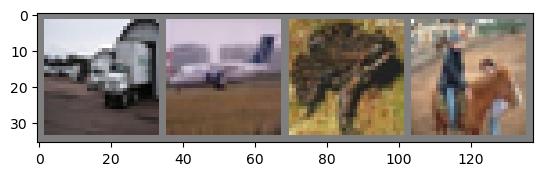

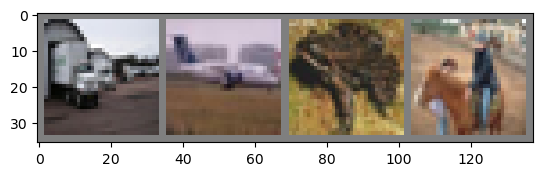

In [34]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [35]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4773784012855515, train acc: 0.4689213893967093
 val loss: 1.2933880595450706, val acc: 0.5495567376309253

Epoch 1
 train loss: 1.1740304282857905, train acc: 0.5887225776965265
 val loss: 1.1115458906965052, val acc: 0.6157136523977239

Epoch 2
 train loss: 1.0657224917760497, train acc: 0.6277381496629941
 val loss: 1.0773421363627658, val acc: 0.6298315603682335

Epoch 3
 train loss: 1.0046434223760852, train acc: 0.6492230347349177
 val loss: 1.0421174749414972, val acc: 0.6455008865670955

Epoch 4
 train loss: 0.969280466628031, train acc: 0.6633014494801788
 val loss: 0.9639608380642343, val acc: 0.664472517815042

Epoch 5
 train loss: 0.9411184467388899, train acc: 0.6741969182242858
 val loss: 0.9660768448038304, val acc: 0.6681515957446809

Epoch 6
 train loss: 0.9209102911966592, train acc: 0.6803669365058216
 val loss: 0.9747037329572312, val acc: 0.6637411348363187

Epoch 7
 

Посчитайте точность на тестовой выборке:

In [36]:
loss_, acc_ = test(net, test_loader)
np.mean(acc_)

0.7241242038216561

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [37]:
transform_rot_flip = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(30),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader_rot_flip, val_loader_rot_flip, test_loader_rot_flip = get_cifar10_data(batch_size=64, transform_train=transform_rot_flip)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader_rot_flip, val_loader_rot_flip, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5984861885607788, train acc: 0.4242866936614788
 val loss: 1.4200157921364966, val acc: 0.4951241134329045

Epoch 1
 train loss: 1.383081032109653, train acc: 0.5091611713552388
 val loss: 1.354893022395195, val acc: 0.5108377659574468

Epoch 2
 train loss: 1.29242751193003, train acc: 0.5396072734862403
 val loss: 1.2314868472992107, val acc: 0.5627437944107867

Epoch 3
 train loss: 1.2257335828906657, train acc: 0.5645362692297704
 val loss: 1.2121696302231322, val acc: 0.5682845744680851

Epoch 4
 train loss: 1.1859450657363348, train acc: 0.5834747975661506
 val loss: 1.146438563630936, val acc: 0.5975842199427016

Epoch 5
 train loss: 1.1572941166827186, train acc: 0.5949170801931587
 val loss: 1.1198634794417848, val acc: 0.6033687942839684

Epoch 6
 train loss: 1.1323393535352495, train acc: 0.601997094572789
 val loss: 1.145827933067971, val acc: 0.5991134752618505

Epoch 7
 train

In [38]:
loss_, acc_ = test(net, test_loader)
np.mean(acc_)

0.6957603503184714

In [39]:
transform_crop_jitter = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.ColorJitter(brightness=0.5, contrast=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader_crop_jitter, val_loader_crop_jitter, test_loader_crop_jitter = get_cifar10_data(batch_size=64, transform_train=transform_crop_jitter)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader_crop_jitter, val_loader_crop_jitter, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.763904519447243, train acc: 0.3576651867172618
 val loss: 1.6046598135156835, val acc: 0.4160904255319149

Epoch 1
 train loss: 1.4986570474216663, train acc: 0.4638694828781393
 val loss: 1.4371497844127898, val acc: 0.4900265957446808

Epoch 2
 train loss: 1.3797380152742431, train acc: 0.5119646121858461
 val loss: 1.347200097936265, val acc: 0.5282801417594261

Epoch 3
 train loss: 1.3204744260969283, train acc: 0.5361223557531507
 val loss: 1.4238830434515122, val acc: 0.4988696808510638

Epoch 4
 train loss: 1.2752417967785865, train acc: 0.5483032449725777
 val loss: 1.2588011416983098, val acc: 0.5547872340425531

Epoch 5
 train loss: 1.24460910661129, train acc: 0.567029576959732
 val loss: 1.1924345166125196, val acc: 0.5798758865670955

Epoch 6
 train loss: 1.2027089492276557, train acc: 0.5797327957379971
 val loss: 1.2246545408634428, val acc: 0.5669104609083622

Epoch 7
 tra

In [40]:
loss_, acc_ = test(net, test_loader)
np.mean(acc_)

0.683718152866242

Your answers here:

RandomRotation - Случайно вращает изображение на угол в пределах указанного диапазона (в градусах).

RandomCrop - Случайно обрезает изображение до указанного размера.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [1]:
import wandb

In [27]:
wandb.login()

True

In [28]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        data = data.to(device)
        target = target.to(device)
        
        logits = model(data)
        loss = nn.functional.cross_entropy(logits, target)
        
        loss_log.append(loss.item())
        
        # <your code here>
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 
        
    wandb.log({"test_acc": np.mean(acc_log), "test_loss": np.mean(loss_log)})


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        
        # <your code here>
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data)
        loss = nn.functional.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        # <your code here>
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item())
        
        wandb.log({"train_acc": acc.item(), "train_loss": loss.item()})


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    wandb.init(
        project='DL_HW2',
        entity='tanpetor2004-hse',
        name='Bonus',
        settings=wandb.Settings(init_timeout=240)
    )

    for epoch in range(n_epochs):
        train_epoch(model, optimizer, train_loader)
        test(model, val_loader)
        print(f"Epoch {epoch}")
        
        if scheduler is not None:
            scheduler.step()

    wandb.finish()
    

In [29]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


test_acc,▁▄▄▅▆▆▆▇▆▆▇▇▇▇▇▇████
test_loss,█▅▅▄▃▃▃▂▃▃▁▂▁▂▂▂▁▂▁▁
train_acc,▁▁▂▁▄▆▆▆▆▅▄▅▆▄▅▅▆▇█▅▇▇▇▅▅▇▆▇▅▇▅▆▆▇▅▇▇▆▆▅
train_loss,▇▆▆▇▆▆▅▅▅▄▅▄▄▄▆▃▄▄▂█▅▆▅█▆▄▅▃▂▅▃▁▂▁▁▂▃▂▄▂
test_acc,0.70915
test_loss,0.84383
train_acc,0.85714
train_loss,0.51086


In [32]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        data = data.to(device)
        target = target.to(device)
        
        logits = model(data)
        loss = nn.functional.cross_entropy(logits, target)
        
        loss_log.append(loss.item())
        
        # <your code here>
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

In [33]:
loss_, acc_ = test(net, test_loader)
np.mean(acc_)

0.7064092356687898